# Displacement information

- files from REACH https://www.reachresourcecentre.info/country/syria/cycle/727/p/2/?toip-group=data&toip=dataset-database#cycle-727
- Data from January 2019, March 2019, April 2019 was not available and has been found here: http://cloud.csiss.gmu.edu/uddi/dataset/humanitarian-situation-overview-in-syria-hsos/resource/3d3bc5e0-0a0e-4d84-9f73-9436c508853c?inner_span=True#
- more data from https://data.humdata.org/dataset/humanitarian-situation-overview-in-syria-hsos


- Data are available continously for: August 2018 - May 2019
- There is also data for April and May 2018 as well as August 2019
- In total there are **13** dataset months

## Columns:

- Displacement/G_QN002_1/QN002_Min_IDPs_lived_in_your_village_last_day_prev_month: Minimal estimation
- Displacement/G_QN002_1/QN002_Max_IDPs_lived_in_your_village_last_day_prev_month: Maximal estimation
- Conf means the confidence interval, for explanation see https://www.impact-repository.org/document/reach/130f8955/reach_syr_terms_of_reference_syria_area_of_origin_methodology_v12_november2015.pdf page 11

## Dataset:

- Is combined in '/Users/hkromer/01_Projects/15.Hack4Good2019/02.Data/01.IMPACT_Data/movement_monitoring/REACH/reach_syr_hsos_combined.csv'

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import re
import geopandas
import geoplot
%matplotlib inline

Import the dataset.

In [2]:
fname = '/Users/hkromer/01_Projects/15.Hack4Good2019/02.Data/01.IMPACT_Data/movement_monitoring/REACH/reach_syr_hsos_combined.csv'
data = pd.read_csv(fname, index_col=0)
data.head()

gov_code distr_code  sbd_code       q_town pre_conf_pop_remained  min_IDPs  \
0     SY05     SY0502  SY050202  Al Amiqiyah                 1-25%       NaN   
1     SY05     SY0502  SY050204     Al Hamra               76-100%     140.0   
2     SY11     SY1101  SY110100    Al Khabas               76-100%       NaN   
3     SY11     SY1103  SY110302     Al Qaraa               76-100%       NaN   
4     SY11     SY1102  SY110201     Al Rasam                26-50%      15.0   

   max_IDPs       month  
0       NaN  august2018  
1     150.0  august2018  
2       NaN  august2018  
3       NaN  august2018  
4      18.0  august2018

Remove all the NaNs

In [3]:
l1 = data.shape[0]
data_reach = data[(data['min_IDPs'].notnull()) | (data['max_IDPs'].notnull())]
l2 = data_reach.shape[0]
print(f'Removed {l1-l2} rows out of {l1} rows ({100.0*(l1-l2)/l1:.2f}%) which had either min or max IDPs to zero.')
data

Removed 4489 rows out of 18426 rows (24.36%) which had either min or max IDPs to zero.


gov_code distr_code  sbd_code       q_town pre_conf_pop_remained  \
0        SY05     SY0502  SY050202  Al Amiqiyah                 1-25%   
1        SY05     SY0502  SY050204     Al Hamra               76-100%   
2        SY11     SY1101  SY110100    Al Khabas               76-100%   
3        SY11     SY1103  SY110302     Al Qaraa               76-100%   
4        SY11     SY1102  SY110201     Al Rasam                26-50%   
...       ...        ...       ...          ...                   ...   
2127     SY07     SY0702  SY070202        C7228               76-100%   
2128     SY02     SY0203  SY020302        C8184                51-75%   
2129     SY02     SY0203  SY020300        C8123                51-75%   
2130     SY02     SY0203  SY020304        C8235                51-75%   
2131     SY07     SY0700  SY070000        C3871                51-75%   

      min_IDPs  max_IDPs       month  
0          NaN       NaN  august2018  
1        140.0     150.0  august2018  
2          NaN       NaN  august2018  
3          NaN       NaN  august2018  
4         15.0      18.0  august2018  
...        ...       ...         ...  
2127     100.0     120.0     may2019  
2128     250.0     260.0     may2019  
2129      90.0     100.0     may2019  
2130     600.0     650.0     may2019  
2131   85000.0   87000.0     may2019  

[18426 rows x 8 columns]

Compare with the original towns from IMPACT, which towns do we have and when?

In [25]:
import pandas as pd
fname_camps = '/Users/hkromer/01_Projects/15.Hack4Good2019/02.Data/03.geolocation_syria/01.exploration.001.camp_locations.csv'
data_camps = pd.read_csv(fname_camps, index_col=0) # read the full camps dataset

def get_lat_long(q_town, data_camps):
    """
    returns the lat and long for a q_town code. 
    """
    data_camp = data_camps[data_camps['town_location_code'] == q_town] # get all info for that one town
    data_camp = data_camp.reset_index(drop=True)
    s = data_camp.loc[:,['town_location_code', 'town_location_name', 'long', 'lat']]
    if len(s) > 0:
        return s.iloc[0]
    else:
        return pd.Series([np.nan,np.nan,np.nan,np.nan], index=['town_location_code', 'town_location_name', 'long', 'lat'])




In [78]:
# import impact dataset (towns)
fname = '/Users/hkromer/01_Projects/15.Hack4Good2019/02.Data/03.geolocation_syria/01.exploration.001.4.IMPACT_locations.with_long_lat.csv'
data_impact = pd.read_csv(fname, index_col=0)

# number of towns in the reach dataset
num_towns_reach = len(data_reach['q_town'].unique())
print(f'{num_towns_reach} unique towns in the reach dataset.')

# number of towns in the impact dataset
num_towns_impact = len(data_impact['town_location_code'].unique())
print(f'{num_towns_impact} unique towns in the impact dataset.')

# which towns in reach dataset are in the impact dataset
towns_reach = data_reach['q_town'].unique()

# How often does one town occur in the dataset
d_towns_reach = data_reach['q_town'].value_counts()

df_reach_towns = pd.DataFrame({'q_town': towns_reach, 'd_towns_reach': d_towns_reach}) # d_towns_reach how often the town occurs
df_reach_towns

1988 unique towns in the reach dataset.
255 unique towns in the impact dataset.


q_town  d_towns_reach
C2256    Al Hamra             13
C3932    Al Rasam             13
C4182  Almontazah             13
C1039    Alshouha             13
C1034   Baar Naif             13
...           ...            ...
C4452       N0398              1
C4998       N0399              1
C2110       C7247              1
C5676       C4205              1
N0424       C1599              1

[1988 rows x 2 columns]

In [79]:
a = df_reach_towns['q_town'].apply(lambda x: get_lat_long(x, data_camps))
a

town_location_code       town_location_name       long        lat
C2256                NaN                      NaN        NaN        NaN
C3932                NaN                      NaN        NaN        NaN
C4182                NaN                      NaN        NaN        NaN
C1039                NaN                      NaN        NaN        NaN
C1034                NaN                      NaN        NaN        NaN
...                  ...                      ...        ...        ...
C4452              N0398                Al Villat  40.736298  36.483067
C4998              N0399               Al Zouhour  40.749835  36.476666
C2110              C7247                Ruwayssat  36.213219  35.774945
C5676              C4205  Kafir (Jisr-Ash-Shugur)  36.322057  35.783348
N0424              C1599      Masudiyeh (Aghtrin)  37.343532  36.494845

[1988 rows x 4 columns]

How many could be found in the location camp set

In [80]:
l1 = a.shape[0]
a = a[a.notnull().any(1)]
l2 = a.shape[0]
print(f'Removed {l1-l2} rows out of {l1} rows ({100.0*(l1-l2)/l1:.2f}%) which had either min or max IDPs to zero.')

Removed 61 rows out of 1988 rows (3.07%) which had either min or max IDPs to zero.


In [81]:
# merge the data back
df_reach_towns = df_reach_towns.merge(a, left_index=True, right_index=True)

Scale the number of occurences

In [82]:
df_reach_towns['ms'] = 60*df_reach_towns['d_towns_reach']/np.max(df_reach_towns['d_towns_reach'])
df_reach_towns

q_town  d_towns_reach town_location_code       town_location_name  \
C1250  C1019             13              C1019         Qanater (Atareb)   
C3945  C1020             13              C1020                   Tuwama   
C1195  C1021             13              C1021                    Babka   
C4268  C1022             13              C1022                   Atareb   
C1037  C1023             13              C1023                   Sahara   
...      ...            ...                ...                      ...   
C4452  N0398              1              N0398                Al Villat   
C4998  N0399              1              N0399               Al Zouhour   
C2110  C7247              1              C7247                Ruwayssat   
C5676  C4205              1              C4205  Kafir (Jisr-Ash-Shugur)   
N0424  C1599              1              C1599      Masudiyeh (Aghtrin)   

            long        lat         ms  
C1250  36.903773  36.056548  60.000000  
C3945  36.809482  36.194153  60.000000  
C1195  36.753668  36.142060  60.000000  
C4268  36.828382  36.137884  60.000000  
C1037  36.842719  36.183161  60.000000  
...          ...        ...        ...  
C4452  40.736298  36.483067   4.615385  
C4998  40.749835  36.476666   4.615385  
C2110  36.213219  35.774945   4.615385  
C5676  36.322057  35.783348   4.615385  
N0424  37.343532  36.494845   4.615385  

[1927 rows x 7 columns]

Plot on the map

 
Red x: locations in IMPACT dataset
Blue o: locations in REACH dataset (size is how often it occurs)


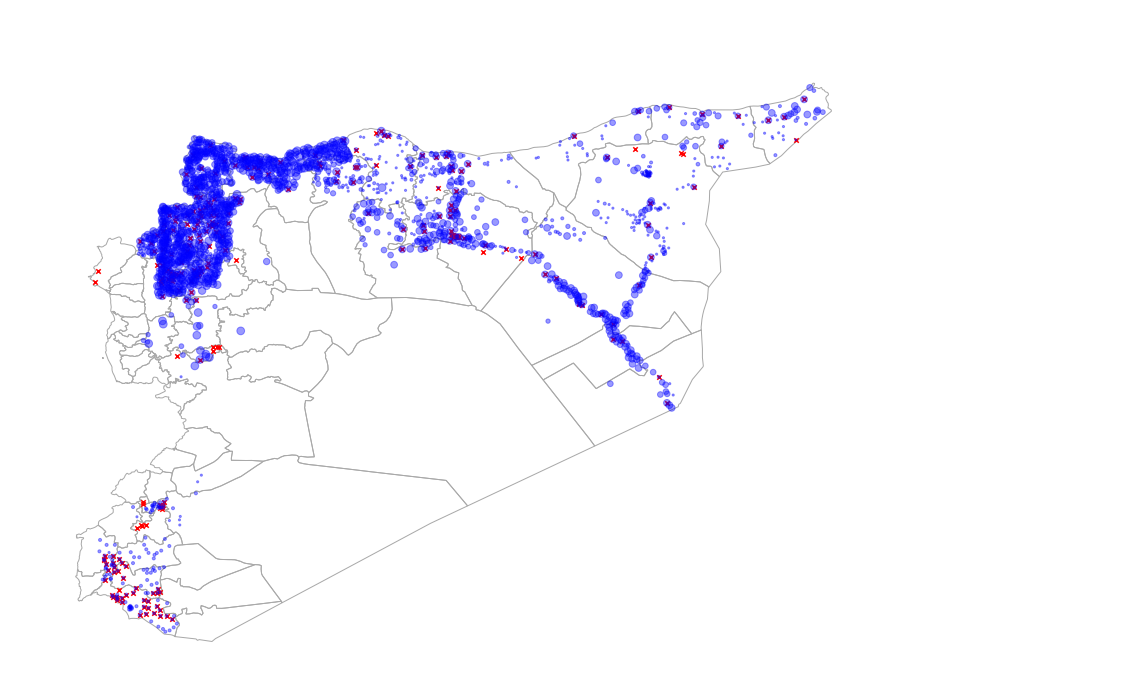

In [83]:
## Plot
# points for impact data
from shapely.geometry import Point # Shapely for converting
# creating a geometry column 
geometry = [Point(xy) for xy in zip(data_impact['long'], data_impact['lat'])]
# Coordinate reference system 
crs = {'init': 'epsg:4326'}
# Creating a Geographic data frame 
gdf_impact = geopandas.GeoDataFrame(data_impact, crs=crs, geometry=geometry)

# points for reach dataset
from shapely.geometry import Point # Shapely for converting
# creating a geometry column 
geometry = [Point(xy) for xy in zip(df_reach_towns['long'], df_reach_towns['lat'])]
# Coordinate reference system 
crs = {'init': 'epsg:4326'}
# Creating a Geographic data frame 
gdf_reach = geopandas.GeoDataFrame(df_reach_towns, crs=crs, geometry=geometry)
shapefile = '/Users/hkromer/01_Projects/15.Hack4Good2019/02.Data/03.geolocation_syria/syr_admin_shp_utf8_19321/syr_admin2.shp'
syria = geopandas.read_file(shapefile)
# syria = geopandas.read_file('/Users/hkromer/01_Projects/15.Hack4Good2019/02.Data/03.geolocation_syria/syr_admin_shp_utf8_19321/syr_pplp_adm4_unocha.shp')


geoplot.polyplot(syria, edgecolor='darkgray', figsize=(20, 20))
ax = plt.gca()
# print(ax.get_ylim())
ax.set_xlim([35,45])
ax.set_ylim([32,38])
# print(ax.get_ylim())
gdf_impact.plot(ax=ax, marker='x', markersize=20, color='red')
gdf_reach.plot(ax=ax, marker='o', markersize=gdf_reach['ms'].values, color='blue', alpha=0.4)

print(' ')
print(f'Red x: locations in IMPACT dataset')
print(f'Blue o: locations in REACH dataset (size is how often it occurs)')

plt.show()

Filter the towns that are in both datasets

In [157]:
data_reach_in_impact = data_reach[data_reach['q_town'].isin(data_impact['town_location_code'])]
print(f'Number of towns in reach that are also in impact (out of {len(data_impact)} impact rows):')
len(data_reach_in_impact['q_town'].unique())

Number of towns in reach that are also in impact (out of 255 impact rows):


218

In [158]:
# add lat and long
data_reach_in_impact = data_reach_in_impact.merge(data_impact[['lat','long','town_location_code']], left_on='q_town', right_on='town_location_code')
assert data_reach_in_impact['q_town'].equals(data_reach_in_impact['town_location_code'])
# add the markersize
data_reach_in_impact = data_reach_in_impact.merge(df_reach_towns[['ms','q_town']], left_on='q_town', right_on='q_town')
len(data_reach_in_impact['q_town'].unique())

216

Note that 2 dropped out because they have no partner?


Get only unique towns

In [159]:
df_towns_reach_in_impact = data_reach_in_impact.drop_duplicates(subset='q_town', keep='first')
df_towns_reach_in_impact['ms'] = df_towns_reach_in_impact['ms'] * 2

/Users/hkromer/anaconda3/envs/h4g/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Plot only these towns

 
Red x: locations in IMPACT dataset
Blue o: locations in REACH dataset (size is how often it occurs)


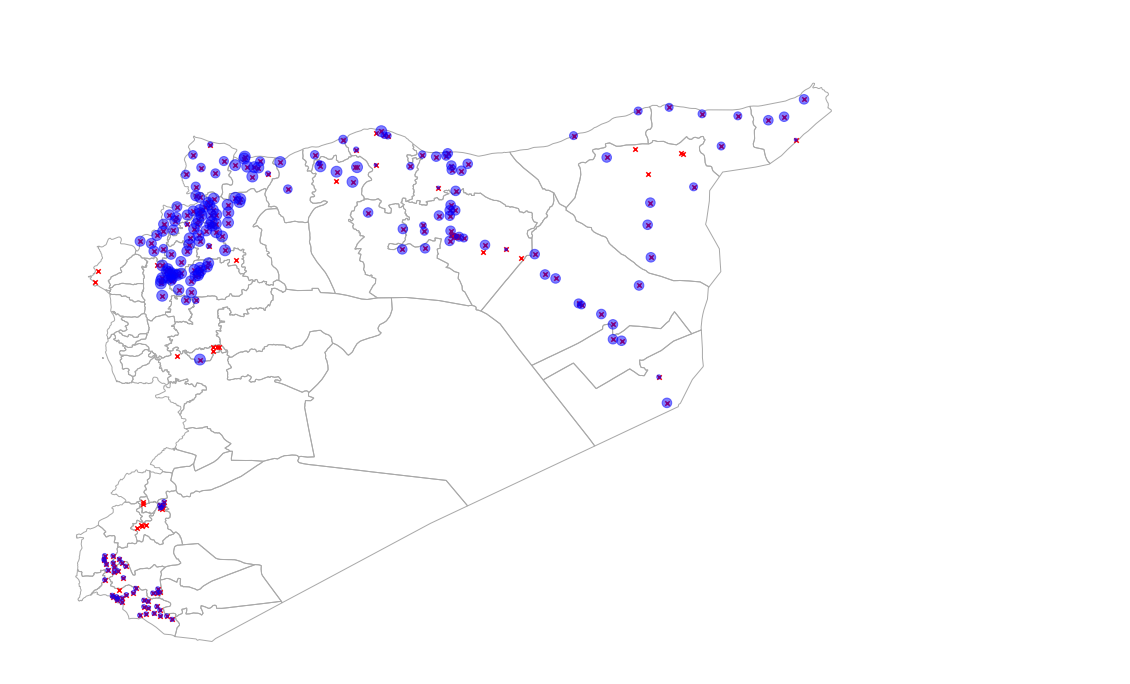

In [163]:
## Plot
# points for impact data
from shapely.geometry import Point # Shapely for converting
# creating a geometry column 
geometry = [Point(xy) for xy in zip(data_impact['long'], data_impact['lat'])]
# Coordinate reference system 
crs = {'init': 'epsg:4326'}
# Creating a Geographic data frame 
gdf_impact = geopandas.GeoDataFrame(data_impact, crs=crs, geometry=geometry)

# points for reach dataset
from shapely.geometry import Point # Shapely for converting
# creating a geometry column 
geometry = [Point(xy) for xy in zip(df_towns_reach_in_impact['long'], df_towns_reach_in_impact['lat'])]
# Coordinate reference system 
crs = {'init': 'epsg:4326'}
# Creating a Geographic data frame 
gdf_reach_in_impact = geopandas.GeoDataFrame(df_towns_reach_in_impact, crs=crs, geometry=geometry)
shapefile = '/Users/hkromer/01_Projects/15.Hack4Good2019/02.Data/03.geolocation_syria/syr_admin_shp_utf8_19321/syr_admin2.shp'
syria = geopandas.read_file(shapefile)
# syria = geopandas.read_file('/Users/hkromer/01_Projects/15.Hack4Good2019/02.Data/03.geolocation_syria/syr_admin_shp_utf8_19321/syr_pplp_adm4_unocha.shp')


geoplot.polyplot(syria, edgecolor='darkgray', figsize=(20, 20))
ax = plt.gca()
# print(ax.get_ylim())
ax.set_xlim([35,45])
ax.set_ylim([32,38])
# print(ax.get_ylim())
gdf_impact.plot(ax=ax, marker='x', markersize=20, color='red')
gdf_reach_in_impact.plot(ax=ax, marker='o', markersize=gdf_reach_in_impact['ms'].values, color='blue', alpha=0.50)

print(' ')
print(f'Red x: locations in IMPACT dataset')
print(f'Blue o: locations in REACH dataset (size is how often it occurs)')
plt.savefig('/Users/hkromer/01_Projects/15.Hack4Good2019/02.Data/01.IMPACT_Data/movement_monitoring/plot_reach_towns_in_impact_locations.pdf')
plt.show()

How many towns have data in all of the months

In [161]:
s = data_reach_in_impact['q_town'].value_counts()
s = s[s.values == np.max(s)]
towns = data_reach_in_impact['q_town'].unique()
print(f'In {len(s)} out of {len(towns)} unique towns ({100.0*len(s)/len(towns):.2f}%) in the reach dataset there is data for {np.max(s)} months.')

In 44 out of 216 unique towns (20.37%) in the reach dataset there is data for 13 months.


Histogram

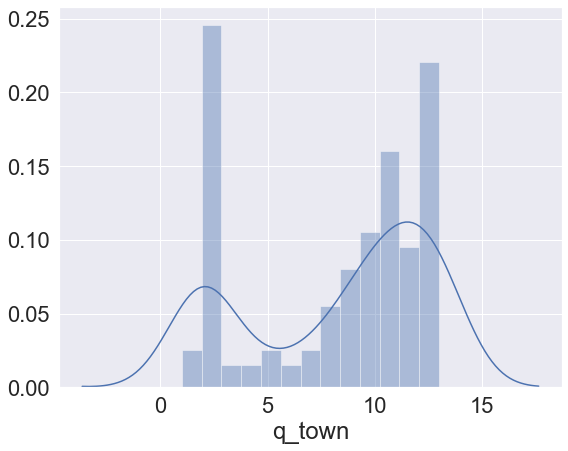

In [162]:
import seaborn as sns
s = data_reach_in_impact['q_town'].value_counts()
fig, ax = plt.subplots(figsize=(9,7))
sns.set(font_scale=2)
sns.distplot(s, ax=ax,bins=13)

plt.show()

Export to csv

In [164]:
fname = '/Users/hkromer/01_Projects/15.Hack4Good2019/02.Data/01.IMPACT_Data/movement_monitoring/02.exploration.displacement.002.REACH_data_towns_in_impact.csv'
data_reach_in_impact.to_csv(fname)